<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/MBComparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab-ready
!pip install colour-science


In [2]:
# === Colab setup ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


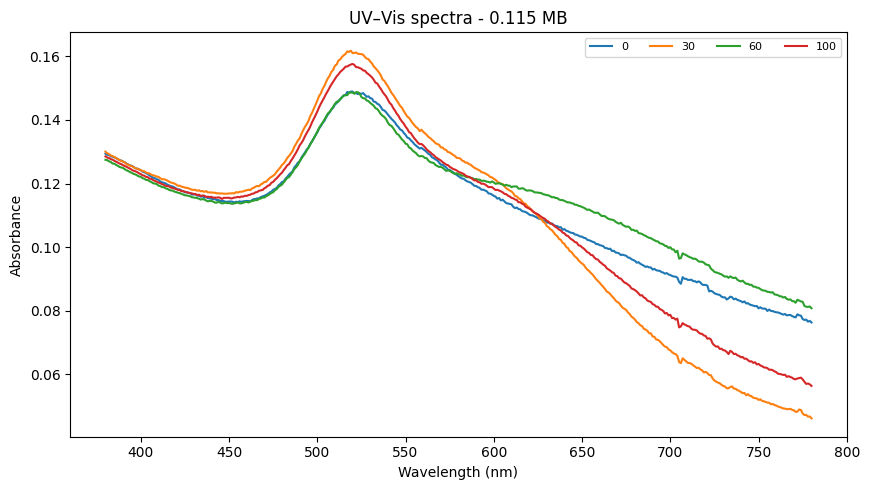

[0.115 MB] concentrations in chip row: 0.0 .. 100.0 (N=201)  RGB range 0.540-0.657


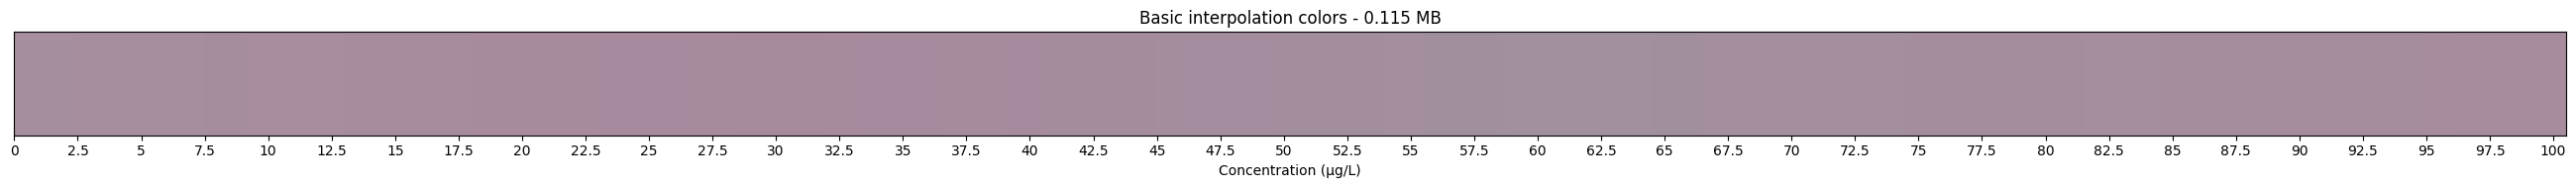

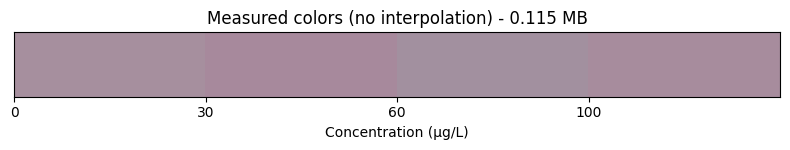

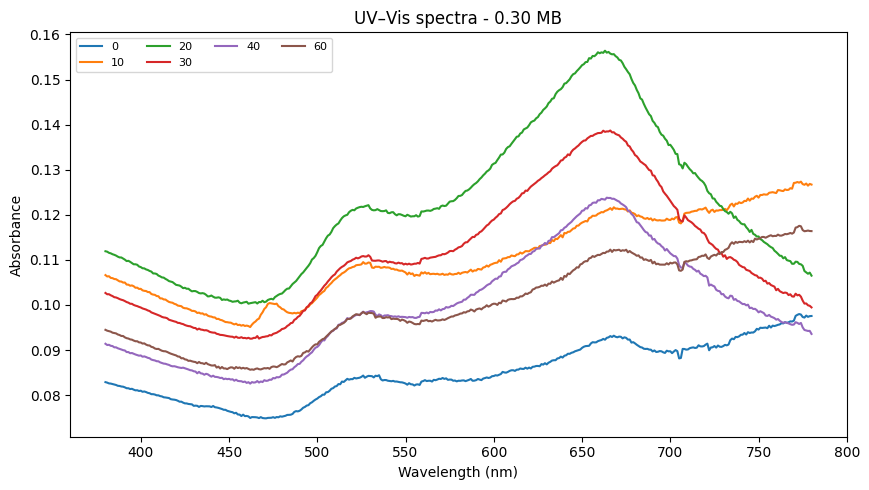

[0.30 MB] concentrations in chip row: 0.0 .. 60.0 (N=121)  RGB range 0.556-0.734


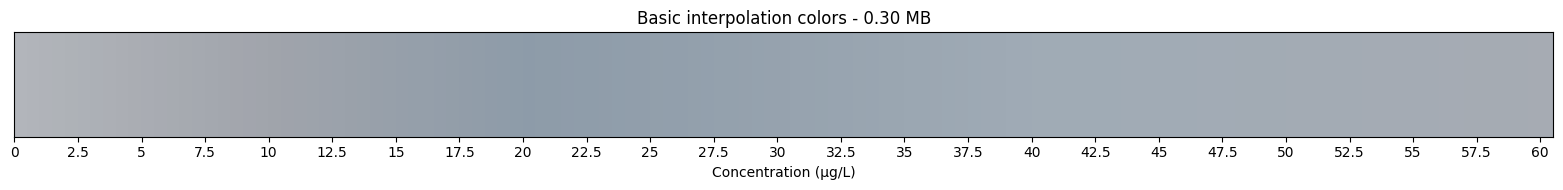

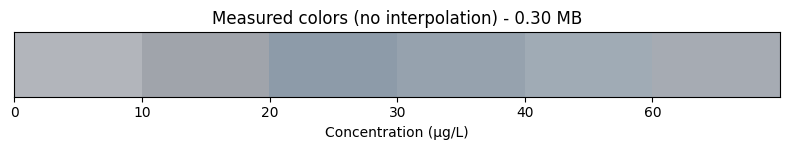

In [10]:
# Colab-ready: Plot spectra + basic-interpolation color chips for BOTH datasets (no model)
# Uses CIE 1931 2° CMFs and D65 via colour-science

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS

# ========= Inputs =========
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0          # controls strength of T = 10^(-ABS_MULT*A)
LABEL_EVERY = 5
GRID_STEP = 0.5         # µg/L step for the basic interpolation chip row

# ========= Colour setup =========
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectra_to_rgb(wavelengths, absorbance):
    """One perceived color from a full spectrum under D65."""
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

    # keep visible only
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    # keep only numeric concentration columns
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]

    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)  # [λ, K]
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def basic_interp_colors(wl, conc_vals, A, step=GRID_STEP):
    """
    Build a chip row by linearly interpolating absorbance across concentration
    onto a uniform grid, then converting each spectrum to one sRGB color.
    """
    c_grid = np.round(np.arange(float(conc_vals.min()), float(conc_vals.max()) + 1e-12, float(step)), 6)
    # interpolate per wavelength
    A_basic = np.vstack([
        np.interp(c_grid, conc_vals, A[i, :])
        for i in range(A.shape[0])
    ])  # [λ, N]
    # color per concentration
    rgb = np.vstack([spectra_to_rgb(wl, A_basic[:, j]) for j in range(A_basic.shape[1])])  # [N,3]
    return c_grid, rgb

def plot_spectra(wl, conc_vals, A, title):
    plt.figure(figsize=(8.8, 5.0))
    for j, c in enumerate(conc_vals):
        label = str(int(c)) if float(c).is_integer() else f"{c}"
        plt.plot(wl, A[:, j], label=label)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorbance")
    plt.title(f"UV–Vis spectra - {title}")
    plt.legend(ncol=4, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_chip_row(concs, rgb, title):
    N = len(concs)
    img = rgb[np.newaxis, :, :]  # 1 x N x 3
    plt.figure(figsize=(max(10, 0.13*N), 2.0))
    plt.imshow(img, aspect="auto", extent=[0, N, 0, 1])
    plt.yticks([])
    ticks = list(range(0, N, LABEL_EVERY))
    plt.xticks(ticks, [f"{concs[i]:g}" for i in ticks])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Basic interpolation colors - {title}")
    plt.tight_layout()
    plt.show()
    # Extra: individual measured concentration chips (no interpolation)
    rgb_measured = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    plt.figure(figsize=(max(8, 0.13*len(conc_vals)), 1.6))
    plt.imshow(rgb_measured[np.newaxis, :, :], aspect="auto",
               extent=[0, len(conc_vals), 0, 1])
    plt.yticks([])
    plt.xticks(range(len(conc_vals)),
               [f"{c:g}" for c in conc_vals])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Measured colors (no interpolation) - {label}")
    plt.tight_layout()
    plt.show()


# ========= Run for both datasets =========
for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)
    plot_spectra(wl, conc_vals, A, label)

    c_grid, rgb = basic_interp_colors(wl, conc_vals, A, step=GRID_STEP)
    # quick sanity
    print(f"[{label}] concentrations in chip row: {c_grid[0]} .. {c_grid[-1]} (N={len(c_grid)})  RGB range {rgb.min():.3f}-{rgb.max():.3f}")
    plot_chip_row(c_grid, rgb, label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


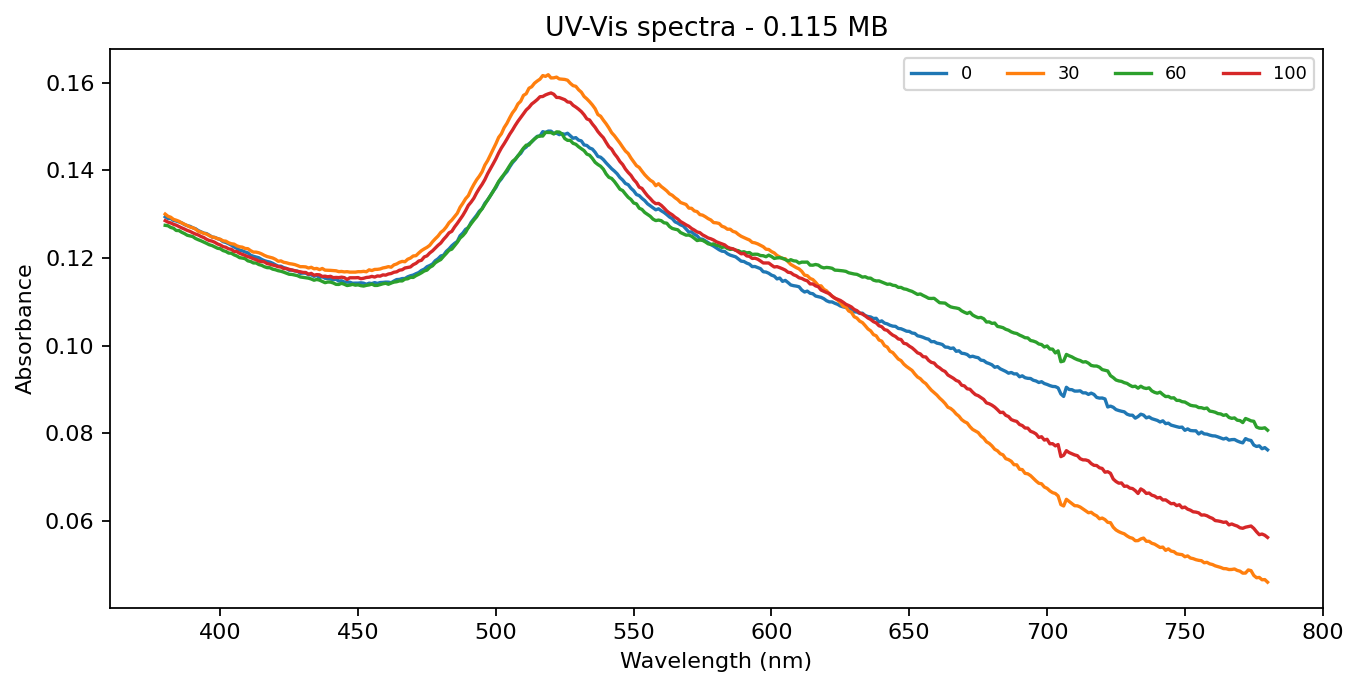

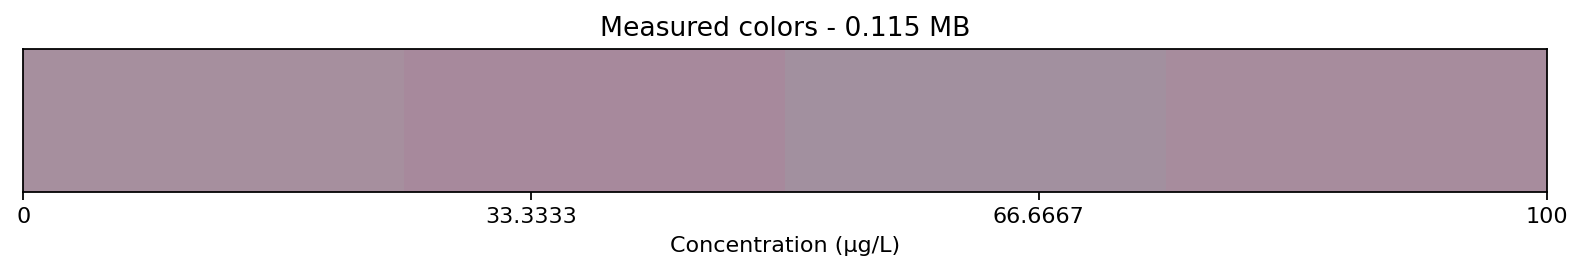

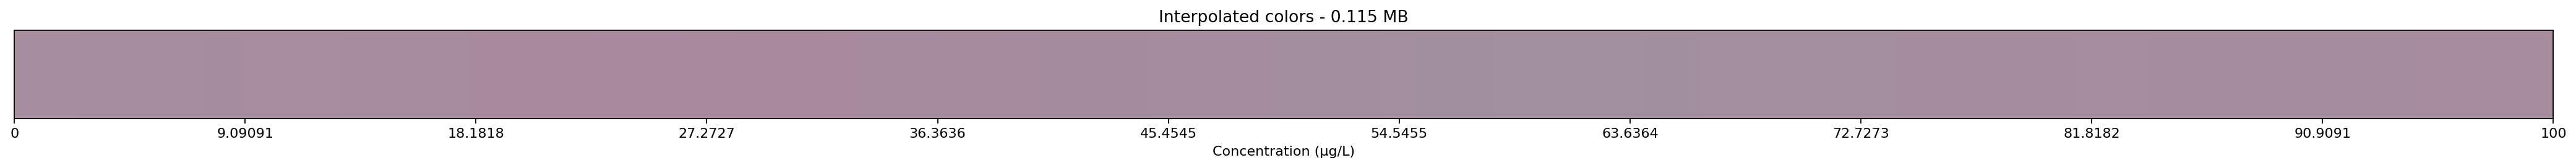

/tmp/ipython-input-137368958.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0


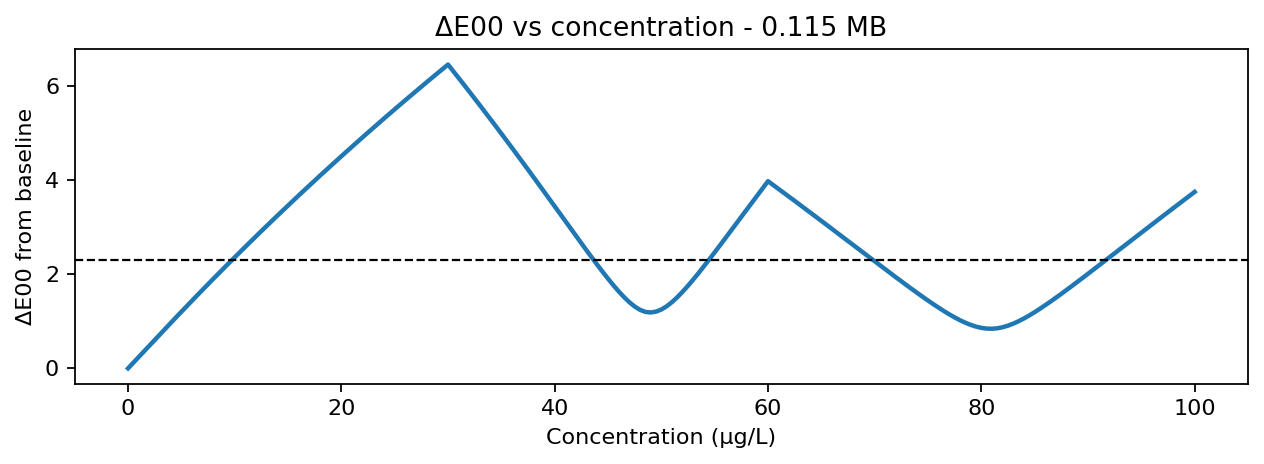

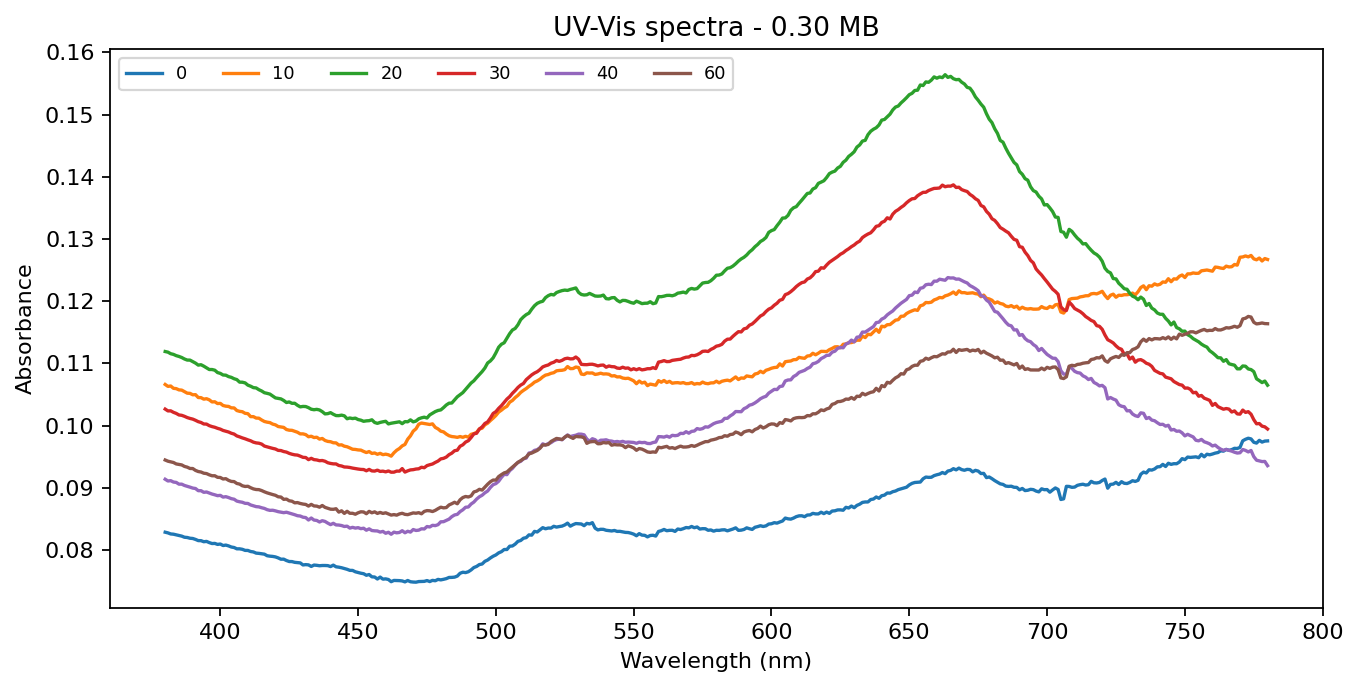

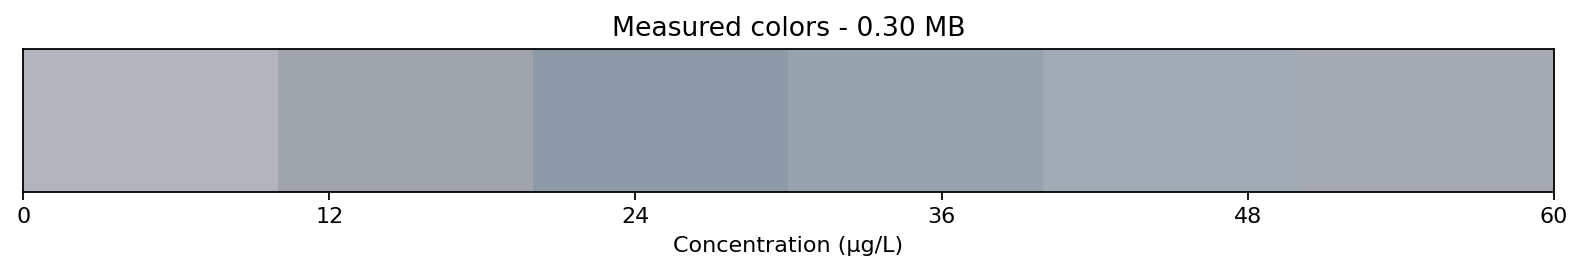

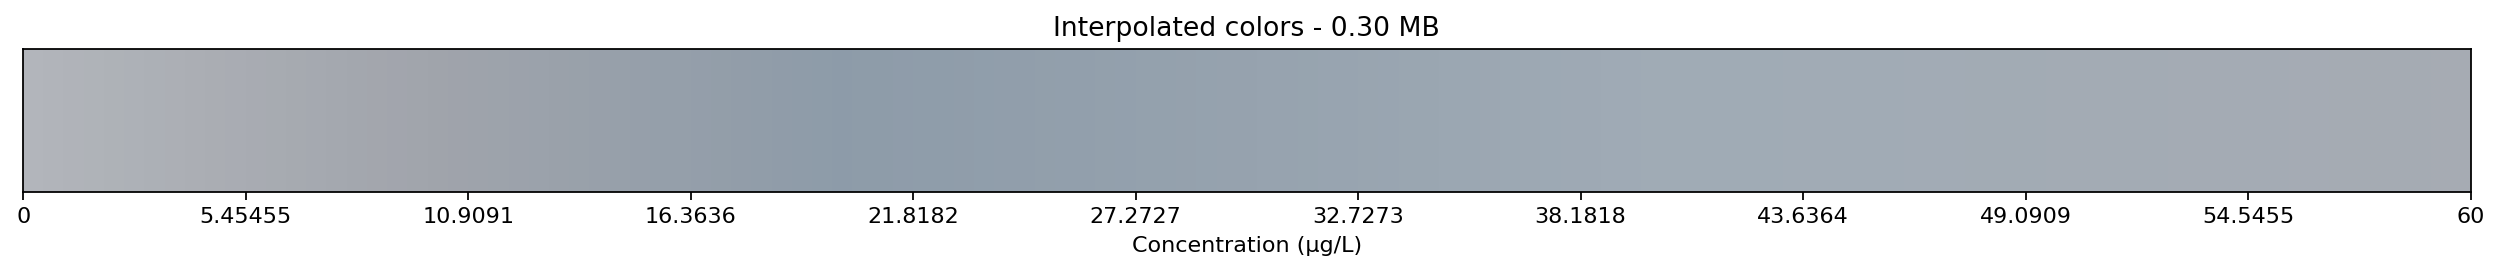

/tmp/ipython-input-137368958.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0


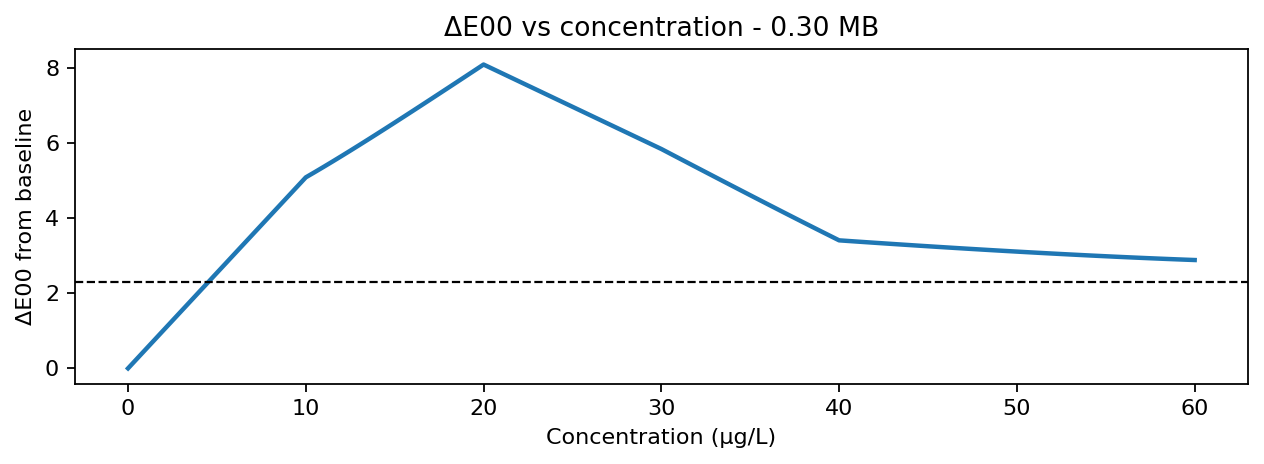


Phone-readout discriminability metrics (higher is better except c_detect):

Mix          | c_detect (µg/L) | min ΔE00 step |  monotone frac |     AUC-ΔE
---------------------------------------------------------------------------
0.115 MB     |              10 | -0.158 | 0.600 | 284.671
0.30 MB      |               5 | -0.124 | 0.333 | 269.090

Suggested winner: 0.30 MB


In [11]:
# Colab-ready: ΔE00 phone-readout metrics for 0.115 MB vs 0.30 MB
# It loads your CSVs, converts spectra to sRGB under D65, computes ΔE00 from the 0 sample,
# and prints: detection threshold, min step, monotone fraction, and AUC.


from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS
from colour.difference import delta_E
plt.rcParams["figure.dpi"] = 160

# ========= Inputs =========
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0           # controls T = 10^(-ABS_MULT*A)
GRID_STEP = 0.5          # concentration step for interpolation
JND = 2.3                 # ΔE00 threshold for "just noticeable"
LABEL_EVERY = 5

# ========= Colour setup =========
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ========= Helpers =========
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must have a 'Wavelength' column"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    # visible only
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    # collect numeric concentration columns
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]

    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)  # [λ, K]
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    """
    Convert a full spectrum to one sRGB under D65 by using transmittance T = 10^(-k*A).
    """
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def basic_interp_colors(wl, conc_vals, A, step):
    c_grid = np.round(np.arange(float(conc_vals.min()),
                                float(conc_vals.max()) + 1e-12,
                                float(step)), 6)
    # interpolate per wavelength across concentration
    A_grid = np.vstack([
        np.interp(c_grid, conc_vals, A[i, :])
        for i in range(A.shape[0])
    ])  # [λ, N]
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])  # [N,3]
    return c_grid, rgb_grid

# sRGB -> XYZ (D65) helper for white reference
def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

from colour import XYZ_to_Lab

def rgb_to_Lab(rgb_array, white_XYZ):
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def evaluate_mix(concs, rgb):
    # use the minimum concentration as the baseline "before" sample
    idx0 = int(np.argmin(concs))
    white_XYZ = srgb_to_XYZ(rgb[idx0])
    Lab = rgb_to_Lab(rgb, white_XYZ)
    Lab0 = Lab[idx0][None, :]
    dE = delta_E(Lab, np.repeat(Lab0, len(Lab), axis=0), method="CIE 2000")

    # metrics
    if np.any(dE >= JND):
        detect_idx = np.argmax(dE >= JND)
        c_detect = float(concs[detect_idx])
    else:
        c_detect = float("inf")
    step_min = float(np.min(np.diff(dE))) if len(dE) > 1 else np.nan
    monotone_frac = float(np.mean(np.diff(dE) > 0)) if len(dE) > 1 else np.nan
    auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0
    return dict(c_detect=c_detect, step_min=step_min, monotone_frac=monotone_frac, auc=auc, dE=dE)

def plot_chip_row(concs, rgb, title):
    N = len(concs)
    img = rgb[np.newaxis, :, :]
    plt.figure(figsize=(max(10, 0.13*N), 1.8))
    plt.imshow(img, aspect="auto", extent=[concs[0], concs[-1], 0, 1])
    plt.yticks([])
    ticks = np.linspace(concs[0], concs[-1], num=min(12, N))
    plt.xticks(ticks, [f"{t:g}" for t in ticks])
    plt.xlabel("Concentration (µg/L)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_dE(concs, dE, title):
    plt.figure(figsize=(8, 3))
    plt.plot(concs, dE, lw=2)
    plt.axhline(JND, ls="--", color="k", lw=1)
    plt.xlabel("Concentration (µg/L)")
    plt.ylabel("ΔE00 from baseline")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ========= Run for both datasets =========
results = {}
for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)

    # spectra plot
    plt.figure(figsize=(8.6, 4.4))
    for j, c in enumerate(conc_vals):
        lab = str(int(c)) if float(c).is_integer() else f"{c}"
        plt.plot(wl, A[:, j], label=lab)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance"); plt.title(f"UV-Vis spectra - {label}")
    plt.legend(ncol=6, fontsize=8); plt.tight_layout(); plt.show()

    # measured chips
    rgb_measured = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    plot_chip_row(conc_vals, rgb_measured, f"Measured colors - {label}")

    # interpolated chips
    c_grid, rgb_grid = basic_interp_colors(wl, conc_vals, A, step=GRID_STEP)
    plot_chip_row(c_grid, rgb_grid, f"Interpolated colors - {label}")

    # metrics
    res = evaluate_mix(c_grid, rgb_grid)
    results[label] = res
    # dE plot
    plot_dE(c_grid, res["dE"], f"ΔE00 vs concentration - {label}")

# ========= Print summary table =========
print("\nPhone-readout discriminability metrics (higher is better except c_detect):\n")
print(f"{'Mix':<12} | {'c_detect (µg/L)':>15} | {'min ΔE00 step':>13} | {'monotone frac':>14} | {'AUC-ΔE':>10}")
print("-"*75)
for k, v in results.items():
    cdet = "∞" if np.isinf(v['c_detect']) else f"{v['c_detect']:.3g}"
    print(f"{k:<12} | {cdet:>15} | {v['step_min']:.3f} | {v['monotone_frac']:.3f} | {v['auc']:.3f}")

# ========= Winner suggestion =========
def winner_by(res_dict):
    # simple lexicographic rule: lower c_detect, then higher min step, then higher monotone_frac, then higher AUC
    items = list(res_dict.items())
    def key_fn(item):
        name, r = item
        c = r['c_detect'] if np.isfinite(r['c_detect']) else 1e9
        return (c, -r['step_min'], -r['monotone_frac'], -r['auc'])
    items.sort(key=key_fn)
    return items[0][0]

print("\nSuggested winner:", winner_by(results))


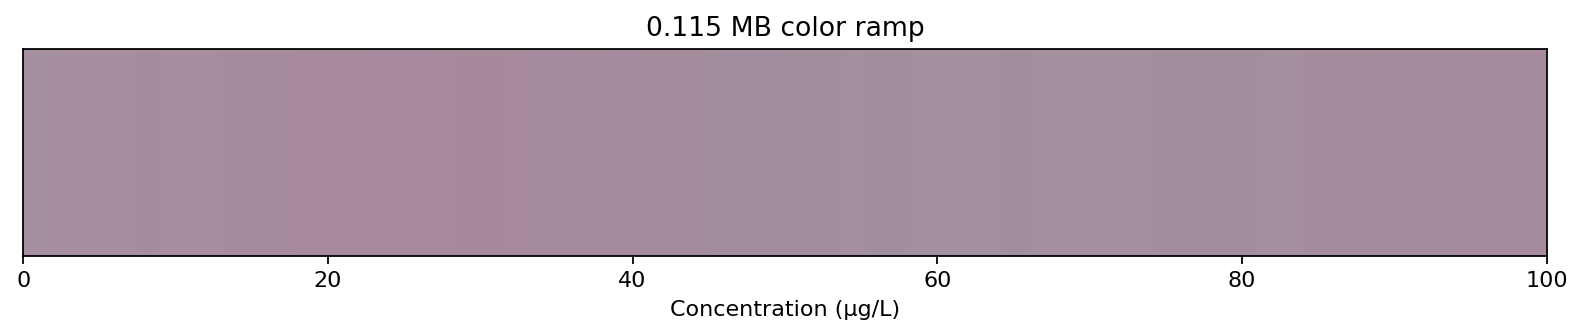

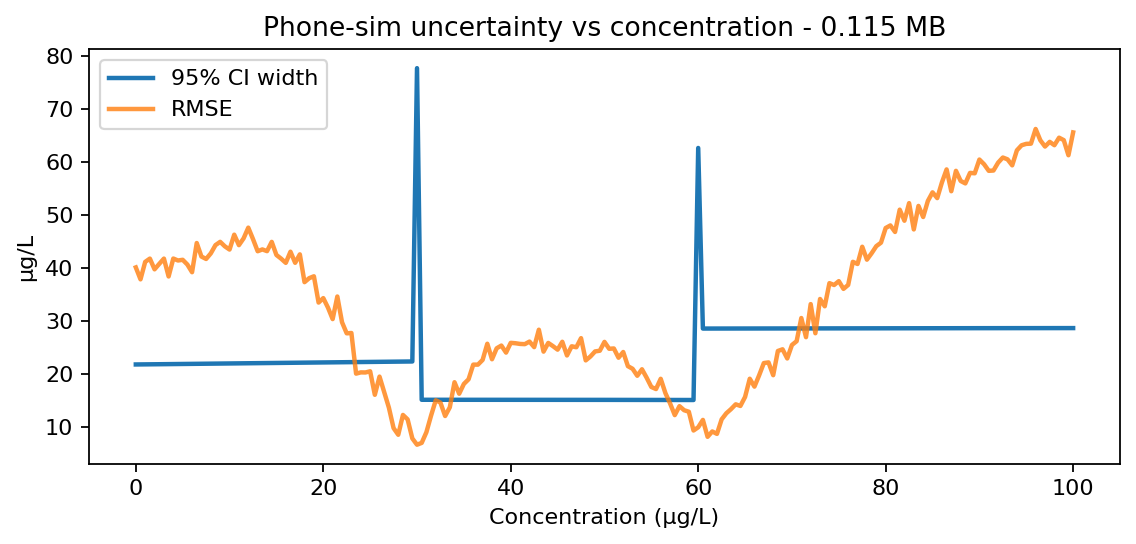

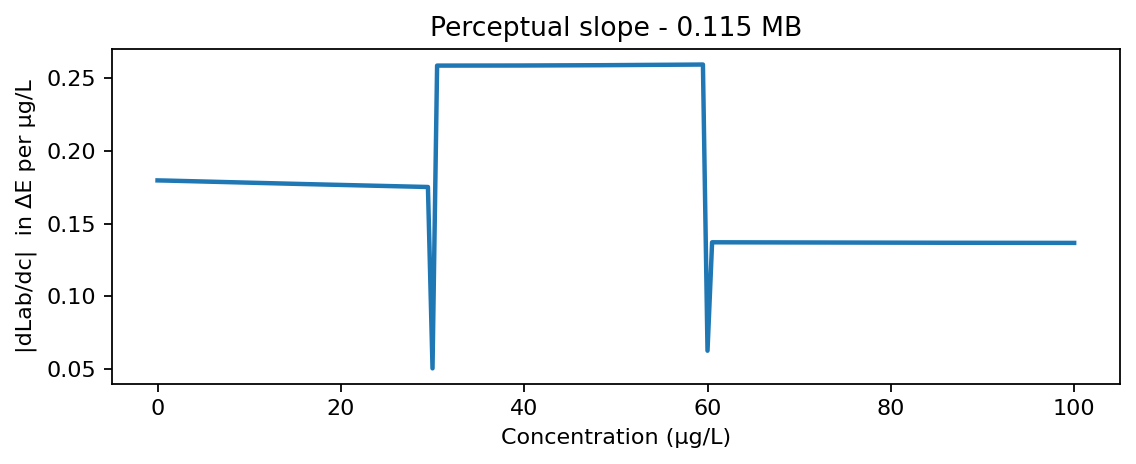

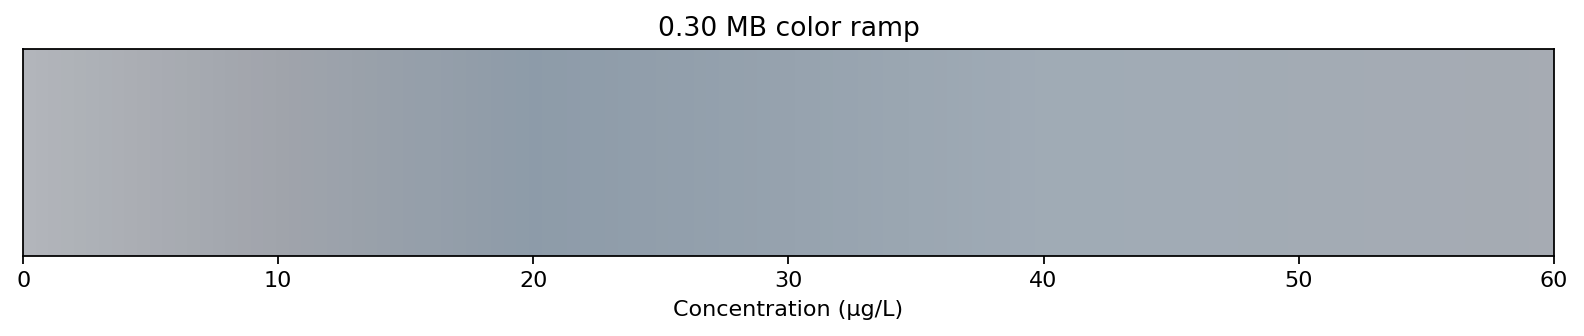

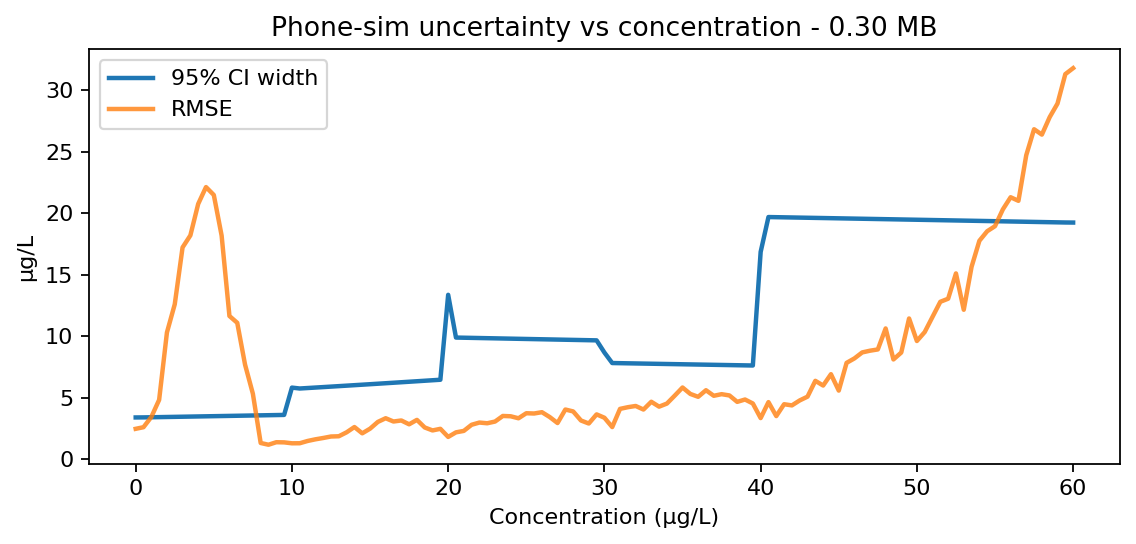

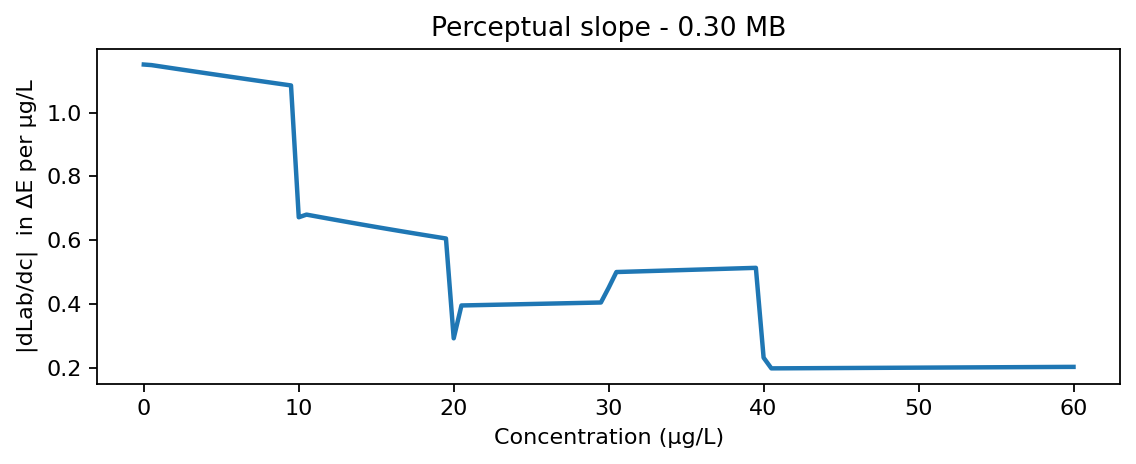


Phone-sim metrics in your range:

Mix          |  median CI |   worst CI |  median RMSE |  worst RMSE
-----------------------------------------------------------------
0.115 MB     | 22.2 | 77.6 | 30.4 | 66.2
0.30 MB      | 9.67 | 19.7 | 4.65 | 31.8

Suggested winner: 0.30 MB


In [12]:
# Phone-simulator for MB 0.115 and MB 0.30
# Confidence is based on local Lab slope vs a small perceptual noise
# Outputs: uncertainty plots, RMSE plots, and summary metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS
from colour import XYZ_to_Lab
plt.rcParams["figure.dpi"] = 160

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0
GRID_STEP = 0.5            # interpolate to a fine grid
SIGMA_JND = 1.0            # phone Lab noise in ΔE units
N_SIMS = 300               # per grid point
RANGE_FOR_DECISION = None  # None uses full range, or tuple like (10, 60)

# ===== Colour setup =====
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ===== Helpers =====
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def build_curve(wl, conc_vals, A, step=GRID_STEP):
    # measured RGB
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    # use lowest conc as white reference
    idx0 = int(np.argmin(conc_vals))
    Lab_meas = rgb_to_Lab_with_white(rgb_meas, rgb_meas[idx0])

    # interpolate A over concentration to a fine grid, then map to Lab
    c_grid = np.round(np.arange(conc_vals.min(), conc_vals.max()+1e-9, step), 6)
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i, :]) for i in range(A.shape[0])])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])

    # arc length coordinate along the curve
    dLab = np.linalg.norm(np.diff(Lab_grid, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(dLab)])  # same length as c_grid

    # local slope magnitude |dLab/dc|
    dc = np.gradient(c_grid)
    dLabdc = np.linalg.norm(np.gradient(Lab_grid, axis=0), axis=1) / (dc + 1e-12)

    return dict(c_grid=c_grid, Lab_grid=Lab_grid, rgb_grid=rgb_grid,
                s=s, dLabdc=dLabdc, Lab0=Lab_grid[np.argmin(c_grid)])

def project_to_curve(Lab_obs, Lab_curve):
    # nearest neighbor along the discrete curve
    idx = np.argmin(np.linalg.norm(Lab_curve - Lab_obs[None, :], axis=1))
    return idx

def simulate_phone(curve, sigma_jnd=SIGMA_JND, n_sims=N_SIMS, use_range=RANGE_FOR_DECISION):
    c = curve["c_grid"]
    Lab = curve["Lab_grid"]
    dLabdc = curve["dLabdc"]

    if use_range is not None:
        lo, hi = use_range
        mask = (c >= lo) & (c <= hi)
    else:
        mask = np.ones_like(c, dtype=bool)

    ests = []
    ci95 = []
    rmse = []
    for i in range(len(c)):
        if not mask[i]:
            ests.append(np.nan); ci95.append(np.nan); rmse.append(np.nan); continue
        # simulate N noisy phone reads at this true concentration
        Lab_true = Lab[i]
        noise = np.random.normal(0.0, sigma_jnd, size=(n_sims, 3))  # ΔE-like isotropic noise
        Lab_noisy = Lab_true[None, :] + noise
        idxs = [project_to_curve(Lab_noisy[k], Lab) for k in range(n_sims)]
        c_hat = c[idxs]
        ests.append(np.median(c_hat))
        rmse.append(np.sqrt(np.mean((c_hat - c[i])**2)))

        # analytic CI using local slope: sigma_c ≈ sigma_Lab / |dLab/dc|
        sigma_c = sigma_jnd / max(dLabdc[i], 1e-9)
        ci95.append(1.96 * sigma_c * 2.0)  # total width

    return dict(c=c, est=np.array(ests), rmse=np.array(rmse), ci95=np.array(ci95),
                dLabdc=dLabdc, mask=mask)

def summarize(sim):
    m = sim["mask"]
    ci = sim["ci95"][m]
    rm = sim["rmse"][m]
    return dict(
        median_CI=np.nanmedian(ci),
        worst_CI=np.nanmax(ci),
        median_RMSE=np.nanmedian(rm),
        worst_RMSE=np.nanmax(rm),
    )

# ===== Run for both datasets =====
curves = {}
sims = {}
summaries = {}

for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)
    curves[label] = build_curve(wl, conc_vals, A, step=GRID_STEP)
    sims[label] = simulate_phone(curves[label], SIGMA_JND, N_SIMS, RANGE_FOR_DECISION)
    summaries[label] = summarize(sims[label])

# ===== Plots =====
for label in FILES.keys():
    cur = curves[label]; sim = sims[label]
    c = cur["c_grid"]; Lab = cur["Lab_grid"]
    # 1) Color ramp with CI whiskers
    img = cur["rgb_grid"][np.newaxis, :, :]
    plt.figure(figsize=(10, 2.2))
    plt.imshow(img, aspect="auto", extent=[c[0], c[-1], 0, 1])
    plt.yticks([])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"{label} color ramp")
    plt.tight_layout(); plt.show()

    # 2) Uncertainty vs concentration
    plt.figure(figsize=(7.2, 3.5))
    plt.plot(c, sim["ci95"], lw=2, label="95% CI width")
    plt.plot(c, sim["rmse"], lw=2, label="RMSE", alpha=0.8)
    plt.ylabel("µg/L")
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Phone-sim uncertainty vs concentration - {label}")
    plt.legend(); plt.tight_layout(); plt.show()

    # 3) Slope magnitude plot
    plt.figure(figsize=(7.2, 3.0))
    plt.plot(c, cur["dLabdc"], lw=2)
    plt.ylabel("|dLab/dc|  in ΔE per µg/L")
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Perceptual slope - {label}")
    plt.tight_layout(); plt.show()

# ===== Print summary and choose winner =====
print("\nPhone-sim metrics in your range:\n")
print(f"{'Mix':<12} | {'median CI':>10} | {'worst CI':>10} | {'median RMSE':>12} | {'worst RMSE':>11}")
print("-"*65)
for k, v in summaries.items():
    print(f"{k:<12} | {v['median_CI']:.3g} | {v['worst_CI']:.3g} | {v['median_RMSE']:.3g} | {v['worst_RMSE']:.3g}")

def winner_by(summ):
    # prefer smaller worst CI, then smaller median CI
    items = list(summ.items())
    items.sort(key=lambda kv: (kv[1]['worst_CI'], kv[1]['median_CI'], kv[1]['worst_RMSE']))
    return items[0][0]

print("\nSuggested winner:", winner_by(summaries))
